In [17]:
from ksvd import ApproximateKSVD
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import DictionaryLearning
from sklearn.linear_model import OrthogonalMatchingPursuit
import imageio.v3 as imageio
from numpy.linalg import norm
from numpy.linalg import inv
from numpy.linalg import pinv
from numpy import dot

# Capacité des méthodes d'apprentissage de dictionnaire à reconnaitre des atomes

In [5]:
def add_white_gaussian_noise(signal, snr_db):
    # Calcul de la puissance du signal = 1/K ici car les atomes de D sont normalisés
    signal_power = np.mean(signal**2)
    noise_power = signal_power / (10**(snr_db / 10))
    
    # Génération du bruit
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    noisy_signal = signal + noise
    
    return noisy_signal


In [11]:
def test_random_signal_db_l(N,snr_db,n_signal,n_components,max_iter,T0):

    true_D = np.random.randn(n_components,n_signal)
    true_D = true_D / np.linalg.norm(true_D,axis = 1).reshape(50,1)  # D un dico aléatoire de 50 signaux de longueur 20
    Y = np.zeros((N,n_signal))
    Y_noise = Y.copy()
    chosen_atoms = []
    for i in range(N):
        chosen_atom = np.random.choice(np.arange(true_D.shape[0]),T0,replace=False)
        lin_values = np.random.uniform(low = 0,high = 3, size = T0)
        Y[i] = np.sum(true_D[chosen_atom]*lin_values.reshape(T0,1),axis=0).reshape(n_signal)
        chosen_atoms.append(chosen_atom)
        Y_noise[i] = add_white_gaussian_noise(Y[i],snr_db) # Ajouter du bruit à nos signaux de Y généré auparavant 
    
    X = ApproximateKSVD(n_components=n_components,max_iter=max_iter,transform_n_nonzero_coefs=T0)
    dictionary = X.fit(Y_noise).components_
  
    matched = 0
    for j in range(dictionary.shape[0]): # Nous comptons le nombre d'atomes reconnus dans cette partie
        distance = [1-np.abs(true_D[i,:].T@dictionary[j,:]) for i in range(true_D.shape[0])]
        if np.min(distance) < 0.01:
            matched += 1
    return matched


In [45]:
def test_random_signal_db_no(N,n_signal,n_components,max_iter,T0):

    true_D = np.random.randn(n_components,n_signal)
    true_D = true_D / np.linalg.norm(true_D,axis = 1).reshape(50,1)  # D un dico aléatoire de 50 signaux de longueur 20
    Y = np.zeros((N,n_signal))
    
    chosen_atoms = []
    for i in range(N):
        chosen_atom = np.random.choice(np.arange(true_D.shape[0]),T0,replace=False)
        lin_values = np.random.uniform(low = 0,high = 3, size = T0)
        Y[i] = np.sum(true_D[chosen_atom]*lin_values.reshape(T0,1),axis=0).reshape(n_signal)
        chosen_atoms.append(chosen_atom)
       
    Y_noise = Y.copy()
    X = ApproximateKSVD(n_components=n_components,max_iter=max_iter,transform_n_nonzero_coefs=T0)
    dictionary = X.fit(Y_noise).components_

    matched = 0
    for j in range(dictionary.shape[0]):
        distance = [1-np.abs(true_D[i,:].T@dictionary[j,:]) for i in range(true_D.shape[0])]
        if np.min(distance) < 0.01:
            matched += 1
    return matched


In [46]:
n_trials = 50
ksvd_0 = np.zeros(n_trials)
ksvd_1 = np.zeros(n_trials)
ksvd_2 = np.zeros(n_trials)
ksvd_3 = np.zeros(n_trials)
for trial in tqdm(range(n_trials)):
    ksvd_0[trial] = test_random_signal_db_no(N=1500,n_signal=20,n_components=50,max_iter=80,T0=3)
    ksvd_1[trial] = test_random_signal_db_l(N=1500,snr_db=30,n_signal=20,n_components=50,max_iter=80,T0=3)
    ksvd_2[trial] = test_random_signal_db_l(N=1500,snr_db=20,n_signal=20,n_components=50,max_iter=80,T0=3)
    ksvd_3[trial] = test_random_signal_db_l(N=1500,snr_db=10,n_signal=20,n_components=50,max_iter=80,T0=3)


100%|██████████| 50/50 [09:59<00:00, 11.99s/it]


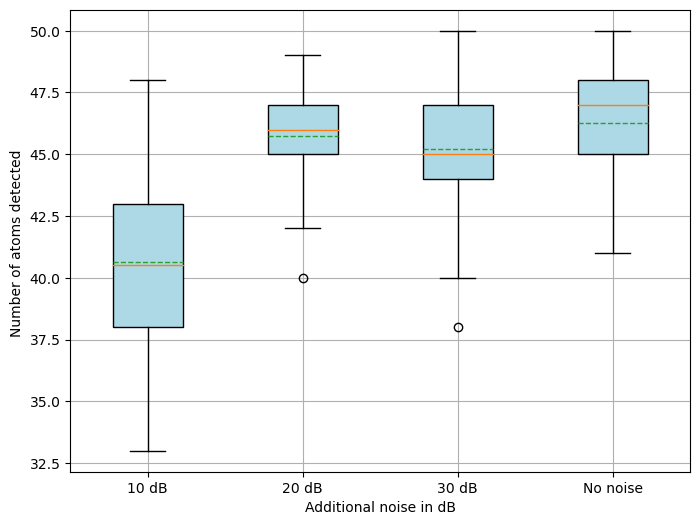

In [48]:

data = [ksvd_3, ksvd_2, ksvd_1,ksvd_0]
means = [np.mean(lst) for lst in data]
mins = [np.min(lst) for lst in data]
maxs = [np.max(lst) for lst in data]
q1s = [np.percentile(lst, 25) for lst in data]
q3s = [np.percentile(lst, 75) for lst in data]

plt.figure(figsize=(8, 6))
plt.boxplot(data, showmeans=True, meanline=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))




plt.grid()
plt.xticks(range(1, 5), ["10 dB", "20 dB", "30 dB","No noise"])
plt.xlabel('Additional noise in dB')
plt.ylabel("Number of atoms detected ")
plt.show()

## MOD avec OMP scipy

In [18]:
def MOD_T(Y:np.ndarray, X:np.ndarray): # étape de mise à jour du dictionnaire dans MOD
    D=dot(dot(Y,X),pinv(dot(X.T,X)))
    return D

In [19]:
def train_MOD(Y, initial_dict , num_iter=80, T0 = 3, dict_update=None,disable_tqdm=False):
    num_iter = num_iter
    Y = Y.copy()
    D = initial_dict.copy()
    for _ in tqdm(range(num_iter),disable=disable_tqdm):
        X = OrthogonalMatchingPursuit(n_nonzero_coefs=T0).fit(D,Y) # Etape de sparse coding
        D = dict_update(Y, X.coef_) # etape de dictionary learning
        D = D / np.linalg.norm(D,axis = 0)
    
    return D, X


In [20]:
def MOD_random_test(N,snr_db,n_signal,n_components,max_iter,T0):
    true_D = np.random.randn(n_signal, n_components)
    true_D /= np.linalg.norm(true_D, axis=0)  
    Y = np.zeros((n_signal,N))
    Y_noise = Y.copy()
    for i in range(N):
        chosen_atom = np.random.choice(np.arange(true_D.shape[1]),T0,replace=False)
        lin_values = np.random.uniform(low = 0,high = 3, size = T0)
        Y[:,i] = np.sum(true_D[:,chosen_atom]*lin_values.reshape(1,T0),axis=1).reshape(n_signal)
        Y_noise[:,i] = add_white_gaussian_noise(Y[:,i],snr_db)
    D = np.random.randn(n_signal, n_components)
    D /= np.linalg.norm(D, axis=0)
    dictionary,X = train_MOD(Y,D,num_iter=max_iter,T0=3,dict_update=MOD_T,disable_tqdm = True) # Seul changement, on utilise MOD au lieu de KSVD
    matched = 0
    for j in range(dictionary.shape[1]):
        distance = [1-np.abs(true_D[:,i].T@dictionary[:,j]) for i in range(true_D.shape[1])]
        if np.min(distance) < 0.01:
            matched += 1
    return matched

In [41]:
n_trials = 50
sigma_0 = np.zeros(n_trials)
sigma_1 = np.zeros(n_trials)
sigma_2 = np.zeros(n_trials)
sigma_3 = np.zeros(n_trials)
for trial in tqdm(range(n_trials)):
    sigma_0[trial] = MOD_random_test(N=1500,snr_db=10,n_signal=20,n_components=50,max_iter=80,T0=3)
    sigma_1[trial] = MOD_random_test(N=1500,snr_db=20,n_signal=20,n_components=50,max_iter=80,T0=3)
    sigma_2[trial] = MOD_random_test(N=1500,snr_db=30,n_signal=20,n_components=50,max_iter=80,T0=3)
    sigma_3[trial] = MOD_random_test(N=1500,snr_db=np.inf,n_signal=20,n_components=50,max_iter=80,T0=3)


100%|██████████| 50/50 [11:39<00:00, 13.98s/it]


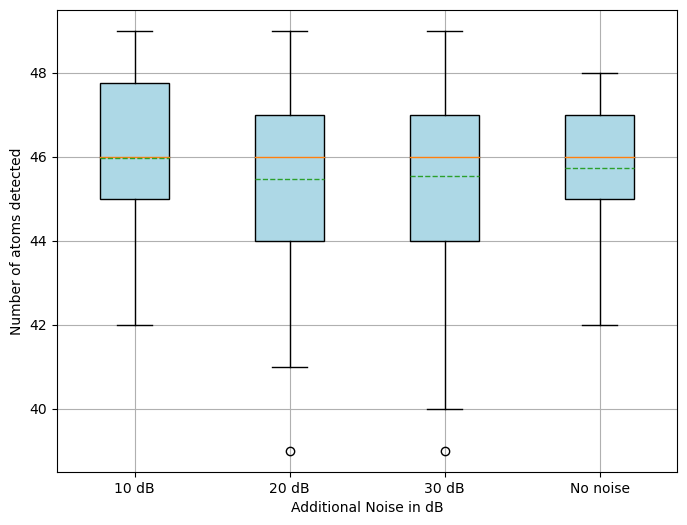

In [42]:

data = [sigma_0,sigma_1,sigma_2,sigma_3]
means = [np.mean(lst) for lst in data]
mins = [np.min(lst) for lst in data]
maxs = [np.max(lst) for lst in data]
q1s = [np.percentile(lst, 25) for lst in data]
q3s = [np.percentile(lst, 75) for lst in data]


plt.figure(figsize=(8, 6))
plt.boxplot(data, showmeans=True, meanline=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))





plt.grid()
plt.xticks(range(1, 5), ["10 dB", "20 dB", "30 dB","No noise"])
plt.xlabel("Additional Noise in dB")
plt.ylabel("Number of atoms detected")
plt.show()


# Plot comparaison

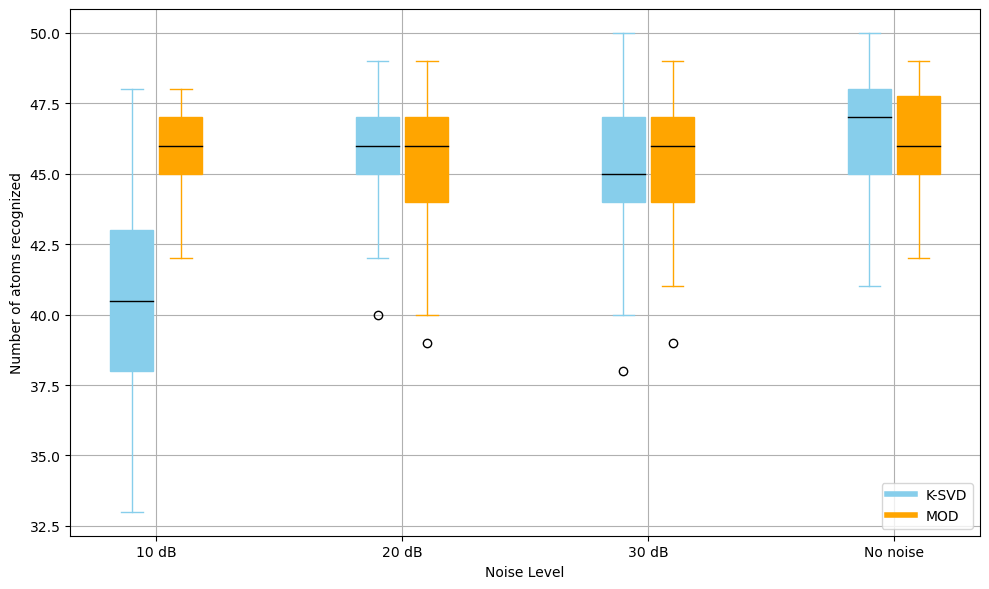

In [55]:

data = [ksvd_3,sigma_3,ksvd_2,sigma_2,ksvd_1,sigma_1,ksvd_0,sigma_0]
colors = ["skyblue", "orange","skyblue", "orange","skyblue", "orange","skyblue", "orange"]
labels = ['10 dB','10 dB','20 dB','20 dB','30 dB','30 dB', 'No noise','No noise']



positions = []
gap = 0.4  
for i in range(1,5):
    positions.append(i * 2)         
    positions.append(i * 2 + gap)    


fig, ax = plt.subplots(figsize=(10, 6))
for pos, color, d in zip(positions, colors, data):
    ax.boxplot(
        d,
        positions=[pos],
        widths=0.35,
        patch_artist=True,
        boxprops=dict(facecolor=color, color=color),
        medianprops=dict(color="black"),
        whiskerprops=dict(color=color),
        capprops=dict(color=color),
    )


ax.grid()
ax.set_xticks([(i * 2 + gap / 2) for i in range(1,5)])
ax.set_xticklabels(['10 dB','20 dB','30 dB', 'No noise'])
ax.set_xlabel("Noise Level")
ax.set_ylabel("Number of atoms recognized")


legend_handles = [
    plt.Line2D([0], [0], color="skyblue", lw=4, label="K-SVD"),
    plt.Line2D([0], [0], color="orange", lw=4, label="MOD"),
]
ax.legend(handles=legend_handles, loc="lower right", bbox_to_anchor=(1, 0))

plt.tight_layout()
plt.show()

# Influence du nombre maximum d'itérations

In [56]:
n_trials = 10
iters = [50,100,150,200,300,500]
ksvd_iter = np.zeros((len(iters),n_trials))
for i,max_iter in enumerate(iters):
    for trial in tqdm(range(n_trials)):
        ksvd_iter[i,trial] = test_random_signal_db_l(N=1500,snr_db=10,n_signal=20,n_components=50,max_iter=max_iter,T0=3)
        

100%|██████████| 10/10 [03:05<00:00, 18.58s/it]


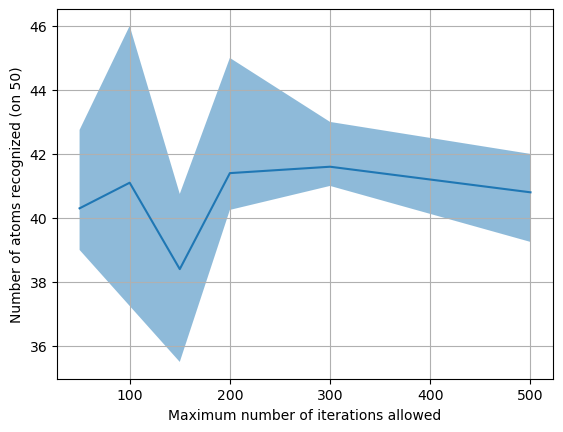

In [57]:
means = [np.mean(lst) for lst in ksvd_iter]
mins = [np.min(lst) for lst in ksvd_iter]
maxs = [np.max(lst) for lst in ksvd_iter]
q1s = [np.percentile(lst, 25) for lst in ksvd_iter]
q3s = [np.percentile(lst, 75) for lst in ksvd_iter]
plt.figure()
plt.grid()
plt.plot(iters,means)
plt.fill_between(iters,q1s,q3s,alpha = 0.5)
plt.xlabel('Maximum number of iterations allowed')
plt.ylabel('Number of atoms recognized (on 50)')
plt.show()

# Influence de la longueur du signal

## 20 dB

In [22]:
n_trials = 20
n_signals = [10,12,14,16,18,20,40]
sigma_0 = np.zeros((len(n_signals),n_trials))
for i,n_signal in enumerate(n_signals):
    for trial in tqdm(range(n_trials)):
        sigma_0[i,trial] = test_random_signal_db_l(N=1500,snr_db=30,n_signal=n_signal,n_components=50,max_iter=80,T0=3)

100%|██████████| 20/20 [01:00<00:00,  3.03s/it]


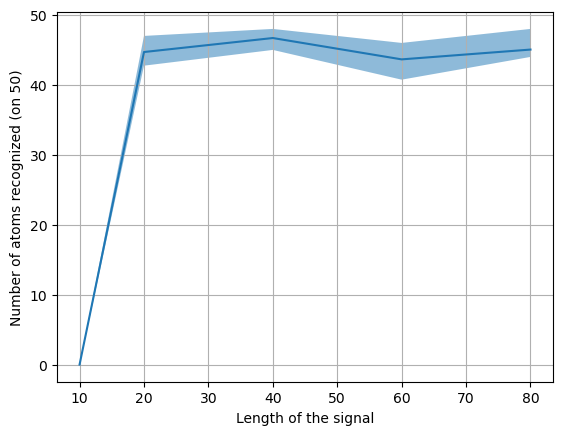

In [23]:
means = [np.mean(lst) for lst in sigma_0]
mins = [np.min(lst) for lst in sigma_0]
maxs = [np.max(lst) for lst in sigma_0]
q1s = [np.percentile(lst, 25) for lst in sigma_0]
q3s = [np.percentile(lst, 75) for lst in sigma_0]
plt.figure()
plt.grid()
plt.plot(n_signals,means)
plt.fill_between(n_signals,q1s,q3s,alpha = 0.5)
plt.xlabel('Length of the signal')
plt.ylabel('Number of atoms recognized (on 50)')
plt.show()

## 10 dB

In [59]:
n_trials = 20
n_signals = [10,12,14,16,18,20,30,40]
ksvd_n = np.zeros((len(n_signals),n_trials))
for i,n_signal in enumerate(n_signals):
    for trial in tqdm(range(n_trials)):
        ksvd_n[i,trial] = test_random_signal_db_l(N=1500,snr_db=10,n_signal=n_signal,n_components=50,max_iter=80,T0=3)

100%|██████████| 20/20 [00:59<00:00,  3.00s/it]


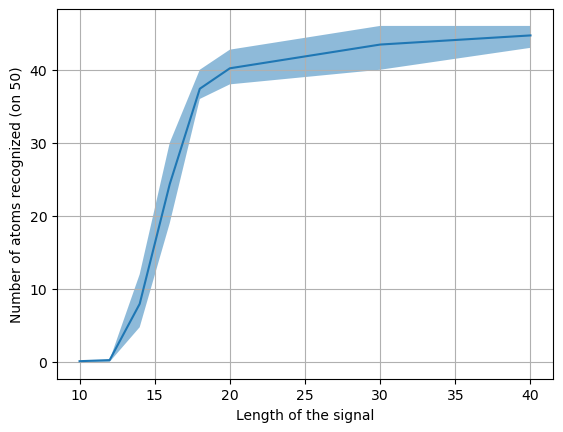

In [61]:
means = [np.mean(lst) for lst in ksvd_n]
mins = [np.min(lst) for lst in ksvd_n]
maxs = [np.max(lst) for lst in ksvd_n]
q1s = [np.percentile(lst, 25) for lst in ksvd_n]
q3s = [np.percentile(lst, 75) for lst in ksvd_n]
plt.figure()
plt.grid()
plt.plot(n_signals,means)
plt.fill_between(n_signals,q1s,q3s,alpha = 0.5)
plt.xlabel('Length of the signal')
plt.ylabel('Number of atoms recognized (on 50)')
plt.show()

# Influence de N

In [66]:
n_trials = 20
N_s  = [100,130,170,200,400,800,1000,1500,2000,3000]
ksvd_N = np.zeros((len(N_s),n_trials))
for i,N_ in enumerate(N_s):
    for trial in tqdm(range(n_trials)):
        ksvd_N[i,trial] = test_random_signal_db_l(N=N_,snr_db=30,n_signal=20,n_components=50,max_iter=80,T0=3)

100%|██████████| 20/20 [01:56<00:00,  5.81s/it]


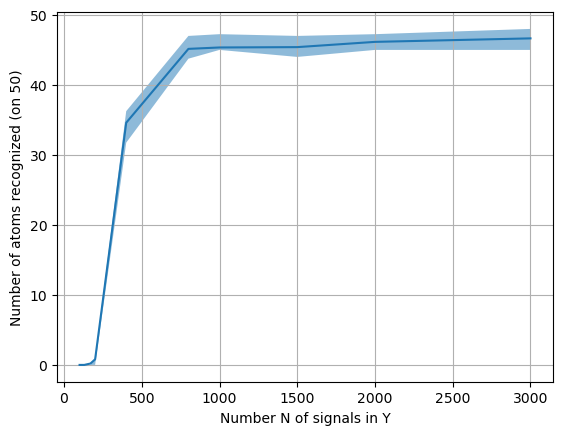

In [67]:
means = [np.mean(lst) for lst in ksvd_N]
mins = [np.min(lst) for lst in ksvd_N]
maxs = [np.max(lst) for lst in ksvd_N]
q1s = [np.percentile(lst, 25) for lst in ksvd_N]
q3s = [np.percentile(lst, 75) for lst in ksvd_N]
plt.figure()
plt.grid()
plt.plot(N_s,means)
plt.fill_between(N_s,q1s,q3s,alpha = 0.5)
plt.xlabel('Number N of signals in Y')
plt.ylabel('Number of atoms recognized (on 50)')
plt.show()